In [299]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from tqdm.notebook import tqdm
from scipy import stats
from scipy.special import exp10

# Important

This notebook **simulates** data based on the correlations, means, and SDs of the original LongROAD data to demonstrate the nested cross-validation procedure. Simulated data are generated by drawing from a multivariate normal distribution given the means, covariance matrix, and sample size. For simplicity, we did not enforce dummy variables to take binary values in the simulated data. Because the simulated nature of the dataset, the results will not exactly replicate the analysis based on real data. However, the general pattern should be pretty close. Indeed, as shown below, we reproduced key patterns seen in the original data. Specifically, the significant out-of-sample prediction performance for physical decline, life satisfaction, fatigue, and role constraints.

The nested CV procedure will output participant-level prediciton errors to the "cv_errors/simulated" folder. Use the `plot_nestedCV.R` to generate a rank plot and compare it to the figure in the manuscript.

In [ ]:
# read correlation matrix
R = pd.read_csv('../data/shareable/correlation_matrix.csv')
R.index = R.columns
descriptive_stats = pd.read_csv('../data/shareable/aggregate_descriptive_stats.csv')

In [301]:
# column names
ivs = ['DaysDriving',
        'Miles_n',
        "Trips", 
        "TripMinutes_n",
        "TripChains",
        "MilesPerTrip_n", 
        "MinutesPerTrip_n",
        "MilesPerChain_n",  
        "MinutesPerChain_n", 
        "Average_speed",
        "LeftTurnCount", 
        "RightToLeftTurnRatio_n",
        "TripsAMPeak", 
        "PercentTripsAMPeak_n",
        "TripsPMPeak", 
        "PercentTripsPMPeak_n",  
        "TripsAtNight", 
        "PercentTripsAtNight_n",
        "TripsLt15Miles", 
        "PercentDistLt15Miles_n",
        "TripsVgt60", 
        "PercentTripsVgt60_n", 
        "SpeedingPer1000Miles", 
        "DecelerationPer1000Miles"]

dvs = ['LIFESATISFACTION','cog','phys','fati','socialrole', 'info', 'emo', 'iso', 'ins', 'anx','dep','ang']

#demos_cat = ['Site', 'GENDER', 'RACE_ETH', 'WORK', 'MARRIAGE']
# dummy variables are already created in the correlation matrix
demos_cat = ['Site_JHSPH', 'Site_UCDENVER', 'Site_UCSD', 'Site_UMTRI', 
       'GENDER_Female', 'RACE_Black', 'RACE_American_Indian',
       'RACE_Asian', 'RACE_Alaska_Native_Native_Hawaiian_Pacific_Islander',
       'RACE_Other_Non_Hispanic', 'RACE_Hispanic', 
       'WORK_Working', 'MARRIAGE_Living_with_a_partner',
       'MARRIAGE_Separated', 'MARRIAGE_Divorced', 'MARRIAGE_Widowed',
       'MARRIAGE_Never_married']
demos_num = ['Age', 'EDUCATION', 'INCOME']

# subset correlation matrix
R = R.loc[ivs+dvs+demos_num+demos_cat, ivs+dvs+demos_num+demos_cat]

## Simulate Data Based on Correlation Matrix

In [302]:
np.random.seed(0)

means = descriptive_stats[descriptive_stats['Variable'].isin(ivs+dvs+demos_num+demos_cat)]['Mean'].values
sds = descriptive_stats[descriptive_stats['Variable'].isin(ivs+dvs+demos_num+demos_cat)]['SD'].values
n = 2658

# --- Step 1: convert correlation to covariance
cov = np.outer(sds, sds) * R

# --- Step 2: generate multivariate normal data
x = np.random.multivariate_normal(mean=means, cov=cov, size=n)

# --- Step 3: put into DataFrame
dat = pd.DataFrame(x, columns=ivs+dvs+demos_num+demos_cat)

# add subject ID
dat['XID'] = range(1, n+1)

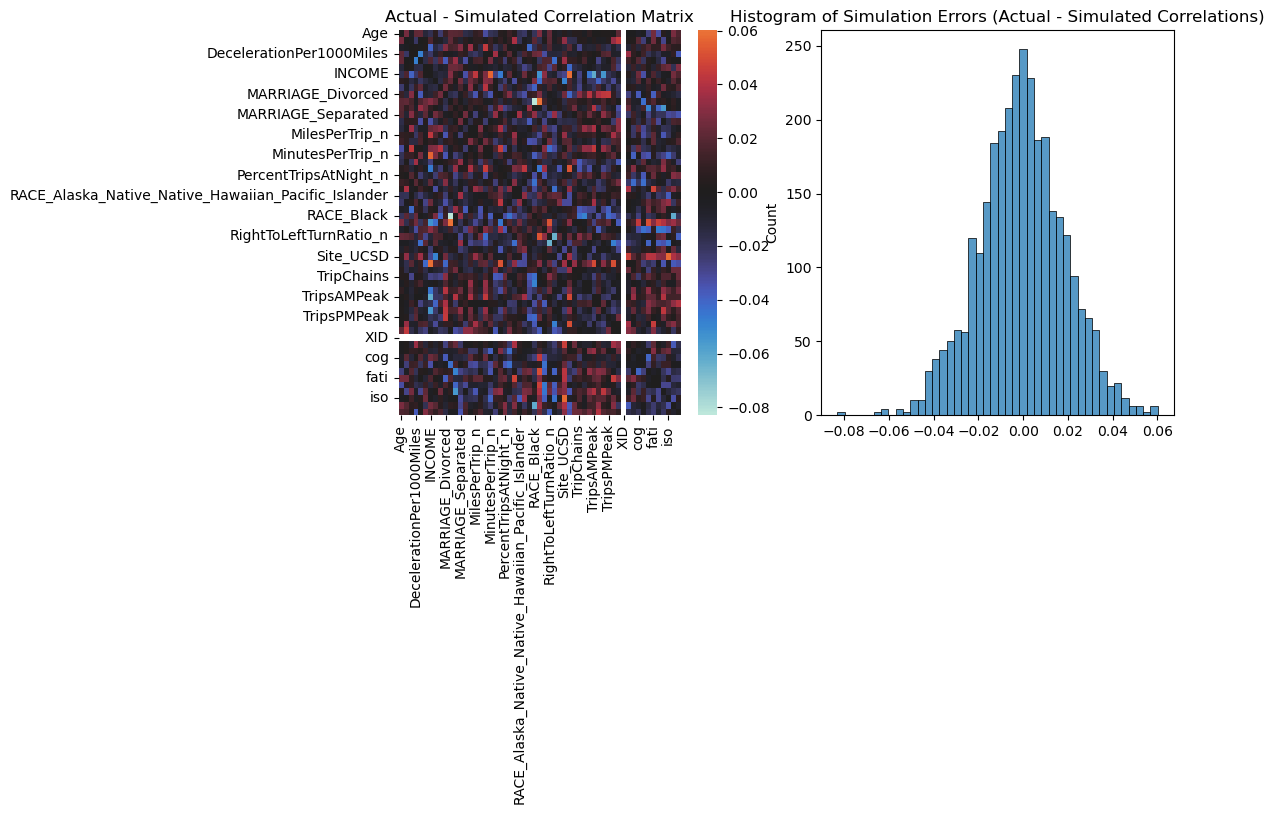

In [303]:
# draw a heatmap of the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap((R-dat.corr()), annot=False, center=0, ax=ax[0])
ax[0].set_title('Actual - Simulated Correlation Matrix')

sns.histplot((R-dat.corr()).values.flatten(), ax=ax[1])
ax[1].set_title('Histogram of Simulation Errors (Actual - Simulated Correlations)')
plt.show()


In [304]:
# scale all dependent variables
dat[dvs] = dat[dvs].apply(lambda x: (x - x.mean()) / x.std(ddof=1))

In [305]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 57 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   DaysDriving                                          2658 non-null   float64
 1   Miles_n                                              2658 non-null   float64
 2   Trips                                                2658 non-null   float64
 3   TripMinutes_n                                        2658 non-null   float64
 4   TripChains                                           2658 non-null   float64
 5   MilesPerTrip_n                                       2658 non-null   float64
 6   MinutesPerTrip_n                                     2658 non-null   float64
 7   MilesPerChain_n                                      2658 non-null   float64
 8   MinutesPerChain_n                                    2658 non-null  

In [306]:
def nested_kfold_ridge(data, numeric_ivs, categorical_ivs, dv, id_col, alphas=None, random_state=0, n_splits_outer=10):
    """
    Nested k-fold CV for Ridge regression with mixed numeric + categorical predictors.
    """
    if alphas is None:
        alphas = np.logspace(np.log10(0.01), np.log10(500), 100)

    X = data[numeric_ivs + categorical_ivs]
    y = data[dv].values
    ids = data[id_col].values

    # Outer loop CV
    outer_cv = KFold(n_splits=n_splits_outer, shuffle=True, random_state=random_state)

    n = len(data)
    errors = np.full(n, np.nan)
    best_alphas = np.full(n, np.nan)
    folds = np.full(n, np.nan)

    for fold_idx, (train_idx, test_idx) in enumerate(tqdm(outer_cv.split(X), total=n_splits_outer, desc="Outer CV")):
        # Split into outer train/test
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # custom preprocessor for numeric and categorical variables
        preprocessor = make_column_transformer(
            (StandardScaler(), numeric_ivs),
            #(OneHotEncoder(drop="first"), categorical_ivs) # no categorical variables in the simulated data
            )

        # Inner CV for hyperparameter tuning
        model = make_pipeline(
            preprocessor,
            RidgeCV(alphas=alphas, scoring='neg_mean_squared_error'),
            )
        model.fit(X_train, y_train)

        # Predict on outer test fold
        y_pred = model.predict(X_test)

        # Store results
        errors[test_idx] = (y_test - y_pred) ** 2
        best_alphas[test_idx] = model.named_steps['ridgecv'].alpha_
        folds[test_idx] = fold_idx

    # Create results dataframe
    results = pd.DataFrame({
        "subject": ids,
        "fold": folds,
        "error": errors,
        "best_alpha": best_alphas
    })

    print('mean of best alphas: ', results.groupby('fold')['best_alpha'].first().mean())
    print('max of best alphas: ', results.groupby('fold')['best_alpha'].first().max())
    print('min of best alphas: ', results.groupby('fold')['best_alpha'].first().min())

    return results


# ---------- Compare Full vs Reduced ----------
def run_nestedCV(data, dv, id_col,
                 numeric_full, categorical_full,
                 numeric_reduced, categorical_reduced, alphas=None,
                 save_path=None):
    """
    Compare full model (driving + demographics) vs reduced model (demographics only).
    """
    # Reduced model (demographics only)
    res_reduced = nested_kfold_ridge(data, numeric_reduced, categorical_reduced, dv, id_col, alphas=alphas)

    # Full model (driving + demographics)
    res_full = nested_kfold_ridge(data, numeric_full, categorical_full, dv, id_col, alphas=alphas)

    # Merge by subject
    res = pd.merge(res_reduced, res_full,
                   on='subject', how='inner',
                   suffixes=('_reduced', '_full'))

    # Difference in MSE (paired)
    res['diff'] = res['error_full'] - res['error_reduced']

    # Paired one-sample t-test
    t_stat, p_value = stats.ttest_1samp(res['diff'], 0, alternative='less')

    print(f"\n=== Results for DV: {dv} ===")
    print(f"MSE (Reduced): {res['error_reduced'].mean():.4f}")
    print(f"MSE (Full):    {res['error_full'].mean():.4f}")
    print(f"Difference (Full - Reduced): {res['diff'].mean():.4f}")
    print(f"T-statistic = {t_stat:.3f}, P-value = {p_value:.4f}")

    # Optionally save
    if save_path:
        res.to_csv(f"{save_path}/{dv}.csv", index=False)

    return res

# Driving + Demographic vs. Demographic Only

In [325]:
# Life Satisfaction 
alphas = np.linspace(0.01, 200, 100)
life_satisfaction = run_nestedCV(
    data=dat, dv = 'LIFESATISFACTION', id_col = 'XID', numeric_full = ivs+demos_num + demos_cat, categorical_full = [], 
    numeric_reduced = demos_num + demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  160.60803030303032
max of best alphas:  171.71858585858587
min of best alphas:  149.49747474747474


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  94.95474747474748
max of best alphas:  111.11555555555556
min of best alphas:  72.73363636363636

=== Results for DV: LIFESATISFACTION ===
MSE (Reduced): 0.8564
MSE (Full):    0.8209
Difference (Full - Reduced): -0.0354
T-statistic = -5.142, P-value = 0.0000


In [327]:
# Cognitive Decline
alphas = np.linspace(5, 100, 100)
cognitive_decline = run_nestedCV(
    data=dat, dv = 'cog', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  12.196969696969695
max of best alphas:  12.676767676767676
min of best alphas:  11.717171717171716


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  31.580808080808072
max of best alphas:  41.464646464646464
min of best alphas:  23.232323232323232

=== Results for DV: cog ===
MSE (Reduced): 0.8646
MSE (Full):    0.8557
Difference (Full - Reduced): -0.0088
T-statistic = -1.769, P-value = 0.0385


In [329]:
# Physical Decline
alphas = np.linspace(0.01, 500, 100)
frailty = run_nestedCV(
    data=dat, dv = 'phys', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  447.47579797979796
max of best alphas:  484.8487878787879
min of best alphas:  404.0423232323232


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  40.41323232323232
max of best alphas:  50.5140404040404
min of best alphas:  35.36282828282828

=== Results for DV: phys ===
MSE (Reduced): 0.9319
MSE (Full):    0.8541
Difference (Full - Reduced): -0.0779
T-statistic = -7.356, P-value = 0.0000


In [335]:
# Fatigue
alphas = np.linspace(100, 1000, 100)
fatigue = run_nestedCV(
    data=dat, dv = 'fati', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  621.8181818181818
max of best alphas:  681.8181818181819
min of best alphas:  545.4545454545455


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  156.36363636363637
max of best alphas:  181.8181818181818
min of best alphas:  127.27272727272728

=== Results for DV: fati ===
MSE (Reduced): 0.9640
MSE (Full):    0.9347
Difference (Full - Reduced): -0.0293
T-statistic = -4.237, P-value = 0.0000


In [340]:
# Social Role Constraints
alphas = np.linspace(0.01, 800, 100)
social_role = run_nestedCV(
    data=dat, dv = 'socialrole', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  659.3956969696969
max of best alphas:  775.7578787878788
min of best alphas:  460.61030303030304


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  132.53359595959597
max of best alphas:  177.78555555555556
min of best alphas:  113.139898989899

=== Results for DV: socialrole ===
MSE (Reduced): 0.9696
MSE (Full):    0.9399
Difference (Full - Reduced): -0.0298
T-statistic = -4.117, P-value = 0.0000


In [341]:
# Informational Support
alphas = np.linspace(0.01, 500, 100)
informational_support = run_nestedCV(
    data=dat, dv = 'info', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  158.08764646464644
max of best alphas:  166.67333333333332
min of best alphas:  146.47171717171716


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  140.4112323232323
max of best alphas:  191.92535353535354
min of best alphas:  95.96767676767678

=== Results for DV: info ===
MSE (Reduced): 0.9011
MSE (Full):    0.8919
Difference (Full - Reduced): -0.0092
T-statistic = -2.063, P-value = 0.0196


In [342]:
# Emotional Support
alphas = np.linspace(0.01, 500, 100)
emotional_support = run_nestedCV(
    data=dat, dv = 'emo', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  167.68341414141415
max of best alphas:  181.82454545454544
min of best alphas:  156.57252525252525


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  133.34066666666666
max of best alphas:  161.62292929292929
min of best alphas:  85.8668686868687

=== Results for DV: emo ===
MSE (Reduced): 0.9209
MSE (Full):    0.9068
Difference (Full - Reduced): -0.0141
T-statistic = -2.744, P-value = 0.0031


In [343]:
# Instrumental Support
alphas = np.linspace(0.01, 100, 100)
instrumental_support = run_nestedCV(
    data=dat, dv = 'ins', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  46.065999999999995
max of best alphas:  48.49
min of best alphas:  43.44


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  56.065
max of best alphas:  64.65
min of best alphas:  43.44

=== Results for DV: ins ===
MSE (Reduced): 0.7924
MSE (Full):    0.7753
Difference (Full - Reduced): -0.0171
T-statistic = -3.330, P-value = 0.0004


In [344]:
# Isolation
alphas = np.linspace(0.01, 500, 100)
isolation = run_nestedCV(
    data=dat, dv = 'iso', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  320.71065656565656
max of best alphas:  393.94151515151515
min of best alphas:  287.8830303030303


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  56.574525252525255
max of best alphas:  141.42131313131313
min of best alphas:  20.211616161616163

=== Results for DV: iso ===
MSE (Reduced): 0.9615
MSE (Full):    0.9491
Difference (Full - Reduced): -0.0124
T-statistic = -2.040, P-value = 0.0207


In [347]:
# Depression
alphas = np.linspace(500, 2000, 100)
depression = run_nestedCV(
    data=dat, dv = 'dep', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  1289.3939393939395
max of best alphas:  1515.1515151515152
min of best alphas:  1075.7575757575758


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  1175.7575757575758
max of best alphas:  1515.1515151515152
min of best alphas:  757.5757575757575

=== Results for DV: dep ===
MSE (Reduced): 0.9862
MSE (Full):    0.9783
Difference (Full - Reduced): -0.0080
T-statistic = -2.188, P-value = 0.0144


In [350]:
# Anxiety
alphas = np.linspace(400, 2000, 100)
anxiety = run_nestedCV(
    data=dat, dv = 'anx', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  1230.707070707071
max of best alphas:  1612.1212121212122
min of best alphas:  739.3939393939395


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  789.4949494949494
max of best alphas:  1078.787878787879
min of best alphas:  416.16161616161617

=== Results for DV: anx ===
MSE (Reduced): 0.9922
MSE (Full):    0.9787
Difference (Full - Reduced): -0.0135
T-statistic = -2.806, P-value = 0.0025


In [351]:
# Anger
alphas = np.linspace(0.01, 1000, 100)
anger = run_nestedCV(
    data=dat, dv = 'ang', id_col = 'XID', numeric_full = ivs+demos_num+demos_cat, categorical_full = [], 
    numeric_reduced = demos_num+demos_cat, categorical_reduced = [], alphas = alphas, save_path='cv_errors/simulated')

Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  375.76381818181824
max of best alphas:  424.2481818181818
min of best alphas:  313.1381818181818


Outer CV:   0%|          | 0/10 [00:00<?, ?it/s]

mean of best alphas:  237.3813636363637
max of best alphas:  343.4409090909091
min of best alphas:  161.62454545454545

=== Results for DV: ang ===
MSE (Reduced): 0.9778
MSE (Full):    0.9745
Difference (Full - Reduced): -0.0033
T-statistic = -0.794, P-value = 0.2136
